In [1]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
import random
from keras import Model
from keras.models import load_model
import numpy as np
import os
import pandas as pd

2021-11-29 15:06:09.509212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-29 15:06:09.509314: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'non_gene_2':'./data/gene/non_gene_2.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed',
    'ATAC_hema_1':'./data/gene/ATAC_hema_1.bed',
    'ATAC_hema_2':'./data/gene/ATAC_hema_2.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Brain':'./data/gene/ATAC_Brain.bed'
    }
TSS_HK = []
with open(dic['TSS_HK'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['1','2','3']:
            TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))
# with open(dic['ATAC_hema_1'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
        


TSS_NonGene = []
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))
# with open(dic['ATAC_Bcell'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1','2','3'] and ll[2] == '0':
#             TSS_NonGene.append(TSS(ll[0],int(ll[1])))

bamfile = ps.AlignmentFile(dic['bam123'],'rb')

TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

TSSes_x = TSS_HK + TSS_NonGene
TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
TSSes_x = np.array(TSSes_x)
TSSes_y = np.array(TSSes_y)
TSSes_x = TSSes_x[perm[:len(perm)]]
TSSes_y = TSSes_y[perm[:len(perm)]]
labels = TSSes_y
up = 1000
down = 1000

In [29]:
'''cnn_input'''
raw_data = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
#    distribution_matrix = np.zeros((int(up+down), 200), dtype=int)
    distribution_matrix = np.zeros((400,200),dtype=int)
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse and 50 < abs(r.isize) < 250:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            if r.reference_start < start:
                continue
            if r.reference_start + abs(r.isize) > end:
                continue
            ss = max(0, r.reference_start - start)
            relative_isize = abs(r.isize)-50
            distribution_matrix[ss//10,relative_isize] += 1
    raw_data.append(distribution_matrix)
raw_data = np.array(raw_data)

cnn_x = []
for mat in raw_data:
    cnn_x.append(mat)
cnn_x = np.array(cnn_x)

In [33]:
train_cnn_x = cnn_x[:int(len(cnn_x)*0.8)]
train_y = labels[:int(len(labels)*0.8)]
test_cnn_x = cnn_x[int(len(cnn_x)*0.8):]
test_y = labels[int(len(labels)*0.8):]

In [49]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, UpSampling1D, Convolution1D, MaxPooling1D, Flatten, Bidirectional,Dropout, AveragePooling1D
from keras.models import Model
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

cnn_input = Input(shape=(cnn_x.shape[1], cnn_x.shape[2]), name='cnn_input')
conv1 = Convolution1D(filters=64, kernel_size=2, strides=1, activation='relu', padding='same',name='conv1')(cnn_input)
conv1 = MaxPooling1D(pool_size=2, strides=2)(conv1)
conv1 = Convolution1D(filters=32, kernel_size=2, strides=1, activation='relu', padding='same')(conv1)
conv1 = MaxPooling1D(pool_size=2, strides=2)(conv1)
conv1 = Convolution1D(filters=16, kernel_size=2, strides=1, activation='relu', padding='same')(conv1)
encoded = MaxPooling1D(pool_size=2, strides=2)(conv1)
x = Convolution1D(filters=32, kernel_size=2, strides=1, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Convolution1D(filters=64, kernel_size=2, strides=1, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Convolution1D(filters=128, kernel_size=2, strides=1, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
decoded = Convolution1D(filters=1, kernel_size=2, strides=1, activation='relu', padding='same')(x)

autoencoder = Model(cnn_input, decoded)
encoder = Model(cnn_input, encoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(train_cnn_x, train_cnn_x,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(test_cnn_x, test_cnn_x)
               )



Epoch 1/100
11/11 [==============================] - 5s 278ms/step - loss: 0.0348 - val_loss: 0.0280
Epoch 2/100
11/11 [==============================] - 2s 215ms/step - loss: 0.0240 - val_loss: 0.0221
Epoch 3/100
11/11 [==============================] - 2s 214ms/step - loss: 0.0213 - val_loss: 0.0212
Epoch 4/100
11/11 [==============================] - 2s 223ms/step - loss: 0.0208 - val_loss: 0.0211
Epoch 5/100
11/11 [==============================] - 3s 233ms/step - loss: 0.0207 - val_loss: 0.0211
Epoch 6/100
11/11 [==============================] - 3s 232ms/step - loss: 0.0206 - val_loss: 0.0210
Epoch 7/100
11/11 [==============================] - 2s 218ms/step - loss: 0.0206 - val_loss: 0.0210
Epoch 8/100
11/11 [==============================] - 3s 233ms/step - loss: 0.0206 - val_loss: 0.0210
Epoch 9/100
11/11 [==============================] - 3s 246ms/step - loss: 0.0206 - val_loss: 0.0210
Epoch 10/100
11/11 [==============================] - 3s 234ms/step - loss: 0.0205 - val_lo

In [59]:
encoder.save('./encoder.h5')

In [58]:
encoded_imgs = encoder.predict(train_cnn_x)
inpt = Input(shape=(encoded_imgs.shape[1], encoded_imgs.shape[2]), name='inp')
# lstm_out = Bidirectional(LSTM(50, return_sequences=True),name='0')(inpt)
x = Convolution1D(filters=100, kernel_size=3, activation='relu',strides=1,padding='same',name='1')(inpt)
x = MaxPooling1D(pool_size=2, strides=2,name='2')(x)
x = Convolution1D(filters=32, kernel_size=3, activation='relu',strides=1,padding='same')(x)
x = MaxPooling1D(pool_size=3, strides=3)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None)(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4')(x)
x = Dropout(0.2)(x)
main_output = Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='6')(x)
model = Model(inputs=inpt, outputs=main_output)

adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(encoded_imgs, train_y, epochs=300, batch_size=2, validation_split=0.1,callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./cnn_0.h5', save_best_only=True)],
                        shuffle=True, verbose=2)

Epoch 1/300
590/590 - 2s - loss: 0.6874 - accuracy: 0.5394 - val_loss: 0.6676 - val_accuracy: 0.6107
Epoch 2/300
590/590 - 1s - loss: 0.6479 - accuracy: 0.6709 - val_loss: 0.5531 - val_accuracy: 0.9237
Epoch 3/300
590/590 - 1s - loss: 0.4935 - accuracy: 0.8142 - val_loss: 0.3279 - val_accuracy: 0.9008
Epoch 4/300
590/590 - 1s - loss: 0.3904 - accuracy: 0.8397 - val_loss: 0.2811 - val_accuracy: 0.9084
Epoch 5/300
590/590 - 1s - loss: 0.3630 - accuracy: 0.8609 - val_loss: 0.2948 - val_accuracy: 0.8855
Epoch 6/300
590/590 - 1s - loss: 0.3418 - accuracy: 0.8711 - val_loss: 0.2705 - val_accuracy: 0.9008
Epoch 7/300
590/590 - 1s - loss: 0.3365 - accuracy: 0.8660 - val_loss: 0.2777 - val_accuracy: 0.9008
Epoch 8/300
590/590 - 1s - loss: 0.3312 - accuracy: 0.8736 - val_loss: 0.2696 - val_accuracy: 0.9008
Epoch 9/300
590/590 - 1s - loss: 0.3276 - accuracy: 0.8779 - val_loss: 0.2639 - val_accuracy: 0.9008
Epoch 10/300
590/590 - 1s - loss: 0.3276 - accuracy: 0.8838 - val_loss: 0.2605 - val_accura

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Convolution1D, MaxPooling1D, Flatten, Bidirectional,Dropout, AveragePooling1D
from keras.models import Model
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

encoding_dim = 2

cnn_input = Input(shape=(x_train.shape[1], ), name='cnn_input')
encoded = Dense(2048,activation='relu')(cnn_input)
encoded = Dense(1024,activation='relu')(encoded)
encoded = Dense(512,activation='relu')(encoded)
encoded = Dense(128,activation='relu')(encoded)
encoded = Dense(64,activation='relu')(encoded)
encoded = Dense(10,activation='relu')(encoded)
encoder_ouput = Dense(encoding_dim,activation='relu')(encoded)
decoded = Dense(10, activation='relu')(encoder_ouput)
decoded = Dense(64,activation='relu')(decoded)
decoded = Dense(128,activation='relu')(decoded)
decoded = Dense(512,activation='relu')(decoded)
encoded = Dense(1024,activation='relu')(encoded)
encoded = Dense(2048,activation='relu')(encoded)
decoded = Dense(x_train.shape[1],activation='tanh')(decoded)

autoencoder = Model(inputs=cnn_input, outputs=decoded)
encoder = Model(inputs=cnn_input, outputs=encoder_ouput)
autoencoder.compile(optimizer='adam',loss='mse')
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True)



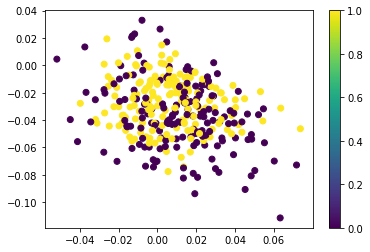

In [24]:
encoded_imgs = encoder.predict(x_test)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=test_y)
plt.colorbar()
plt.show()